# Image Model Training Notebook

It includes data preprocessing, model creation, training, and evaluation.

In [2]:
import sys
import os

import shutil
import random

import tensorflow as tf

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
project_root = os.path.abspath("..")  
sys.path.append(os.path.join(project_root, "models"))

from image_classification_model import ImageClassifier

In [5]:
data_path = "../datasets/images/Animals-10"

class_names = sorted(os.listdir(data_path))
print(class_names)

['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


Let's get some general information about the dataset

In [6]:
class_sizes = []
class_name_size = {}

for name in class_names:
  class_size = len(os.listdir(data_path + '/' + name))
  class_sizes.append(class_size)
  class_name_size[name] = class_size

print("Total number of images: ", sum(class_sizes), '\n')
print("Class Distribution:\n", class_sizes, '\n')
print("Data:\n", class_name_size)

Total number of images:  26179 

Class Distribution:
 [2112, 1668, 3098, 1866, 4863, 1446, 2623, 1820, 4821, 1862] 

Data:
 {'butterfly': 2112, 'cat': 1668, 'chicken': 3098, 'cow': 1866, 'dog': 4863, 'elephant': 1446, 'horse': 2623, 'sheep': 1820, 'spider': 4821, 'squirrel': 1862}


## Visualization of dataset

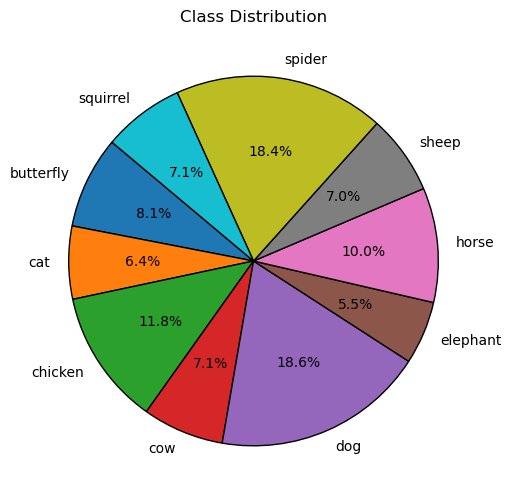

In [ ]:
plt.figure(figsize=(6, 6))
plt.pie(class_sizes, labels=class_names, autopct='%1.1f%%', startangle=140, wedgeprops={'edgecolor': 'black'})
plt.title("Class Distribution")
plt.show()

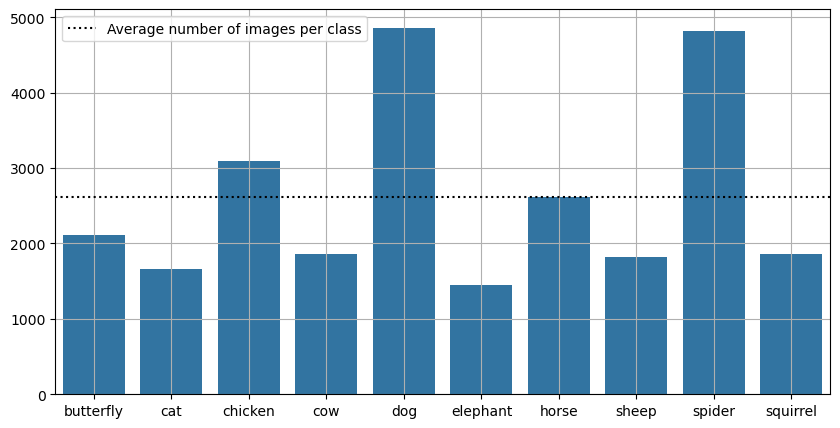

In [19]:
plt.figure(figsize=(10,5))
sns.barplot(x=class_names, y=class_sizes)
plt.grid()
plt.axhline(np.mean(class_sizes), color='black', linestyle=':', label="Average number of images per class")
plt.legend()
plt.show()

## Dataset splitting

This block first selects 70% of the total dataset to reduce training time while maintaining sufficient data for learning. After extracting this subset, it is further split into training and testing sets, where 80% is used for training and 20% for testing. 

In [8]:
input_folder = data_path  
output_folder = '../datasets/images'

# Define ratios
total_data_ratio = 0.7  # Use only 60% of all data
train_ratio = 0.8  # Split selected data: 80% Train, 20% Test

train_dir = os.path.join(output_folder, "train")
test_dir = os.path.join(output_folder, "test")

# Check if train and test folders already exist
if os.path.exists(train_dir) and os.path.exists(test_dir):
    print("Train and test datasets already exist. Skipping dataset splitting.")
else:
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Loop through each class folder
    for class_name in os.listdir(input_folder):
        class_path = os.path.join(input_folder, class_name)
        
        if os.path.isdir(class_path):  
            images = os.listdir(class_path)
            random.shuffle(images) 
            
            selected_count = int(len(images) * total_data_ratio)
            selected_images = images[:selected_count]  

            split_index = int(len(selected_images) * train_ratio)
            train_images, test_images = selected_images[:split_index], selected_images[split_index:]

            os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
            os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

            for img in train_images:
                shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
            
            for img in test_images:
                shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))

    print("Dataset successfully split into train and test (only 60% of total data used)!")

Train and test datasets already exist. Skipping dataset splitting.


## Preparing data for training

In [9]:
train_data_generator = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    vertical_flip = True,
    rotation_range = 20,
    validation_split = 0.2
)

In [10]:
train_data_path = "../datasets/images/train"
test_data_path = "../datasets/images/test"

In [11]:
train_data = train_data_generator.flow_from_directory(
    train_data_path,
    target_size = (256, 256),
    class_mode = 'binary',
    batch_size = 32,
    shuffle = True,
    subset = 'training'
)

Found 16909 images belonging to 10 classes.


In [12]:
valid_data = train_data_generator.flow_from_directory(
    train_data_path,
    target_size = (256, 256),
    class_mode = 'binary',
    batch_size = 32,
    shuffle = True,
    subset = 'validation'
)

Found 4223 images belonging to 10 classes.


In [27]:
test_data_generator = ImageDataGenerator(rescale=1./255)

test_data = test_data_generator.flow_from_directory(
    test_data_path,  
    target_size=(256, 256),
    class_mode='binary',
    batch_size=32,
    shuffle=True  
)

Found 5429 images belonging to 10 classes.


## Image Model 

In [14]:
image_classifier = ImageClassifier()

### TRAINING and SAVING WEIGHTS
If you want to train model by yourself then run this block of cells 

In [ ]:
image_classifier.train(train_data, valid_data)

In [ ]:
image_classifier.save_weights("../src/weights/new_image_model.h5")

### LOADING WEIGHTS

This weights were saved from a model trained with parameters <code>epochs=15, batch_size=32</code>, and the training took approximately 2 hours on Colab using a GPU. The prediction accuracy can improve with a larger number of epochs.<br>
And the result of training was<br>
<i>accuracy: 0.7353 - loss: 0.7766 <br> val_accuracy: 0.5731 - val_loss: 1.3930</i>

In [15]:
image_classifier.load_weights("../src/weights/image_model.h5")

### Visualizing Model Predictions on Testing Data

In [19]:
def show_image(image, image_title=None):
    """
    Displays an image with an optional title.

    Args:
        image (numpy.ndarray): The image to be displayed.
        image_title (str, optional): The title of the image. Defaults to None.

    The function uses Matplotlib to visualize the given image and removes the axis for a cleaner display.
    """
    plt.imshow(image)
    plt.title(image_title)
    plt.axis('off')

In [20]:
def get_random_data(data_tuple):
    """
    Selects a random image and its corresponding label from a dataset.

    Args:
        data_tuple (tuple): A tuple containing images and labels (images, labels).

    Returns:
        tuple: A randomly selected (image, label) pair.

    This function picks a random index from the dataset, extracts the corresponding image and label, and returns them.
    """
    images, labels = data_tuple
    idx = np.random.randint(len(images))
    image, label = images[idx], labels[idx]

    return image, label

1/1 [==============================] - 1s 1s/step


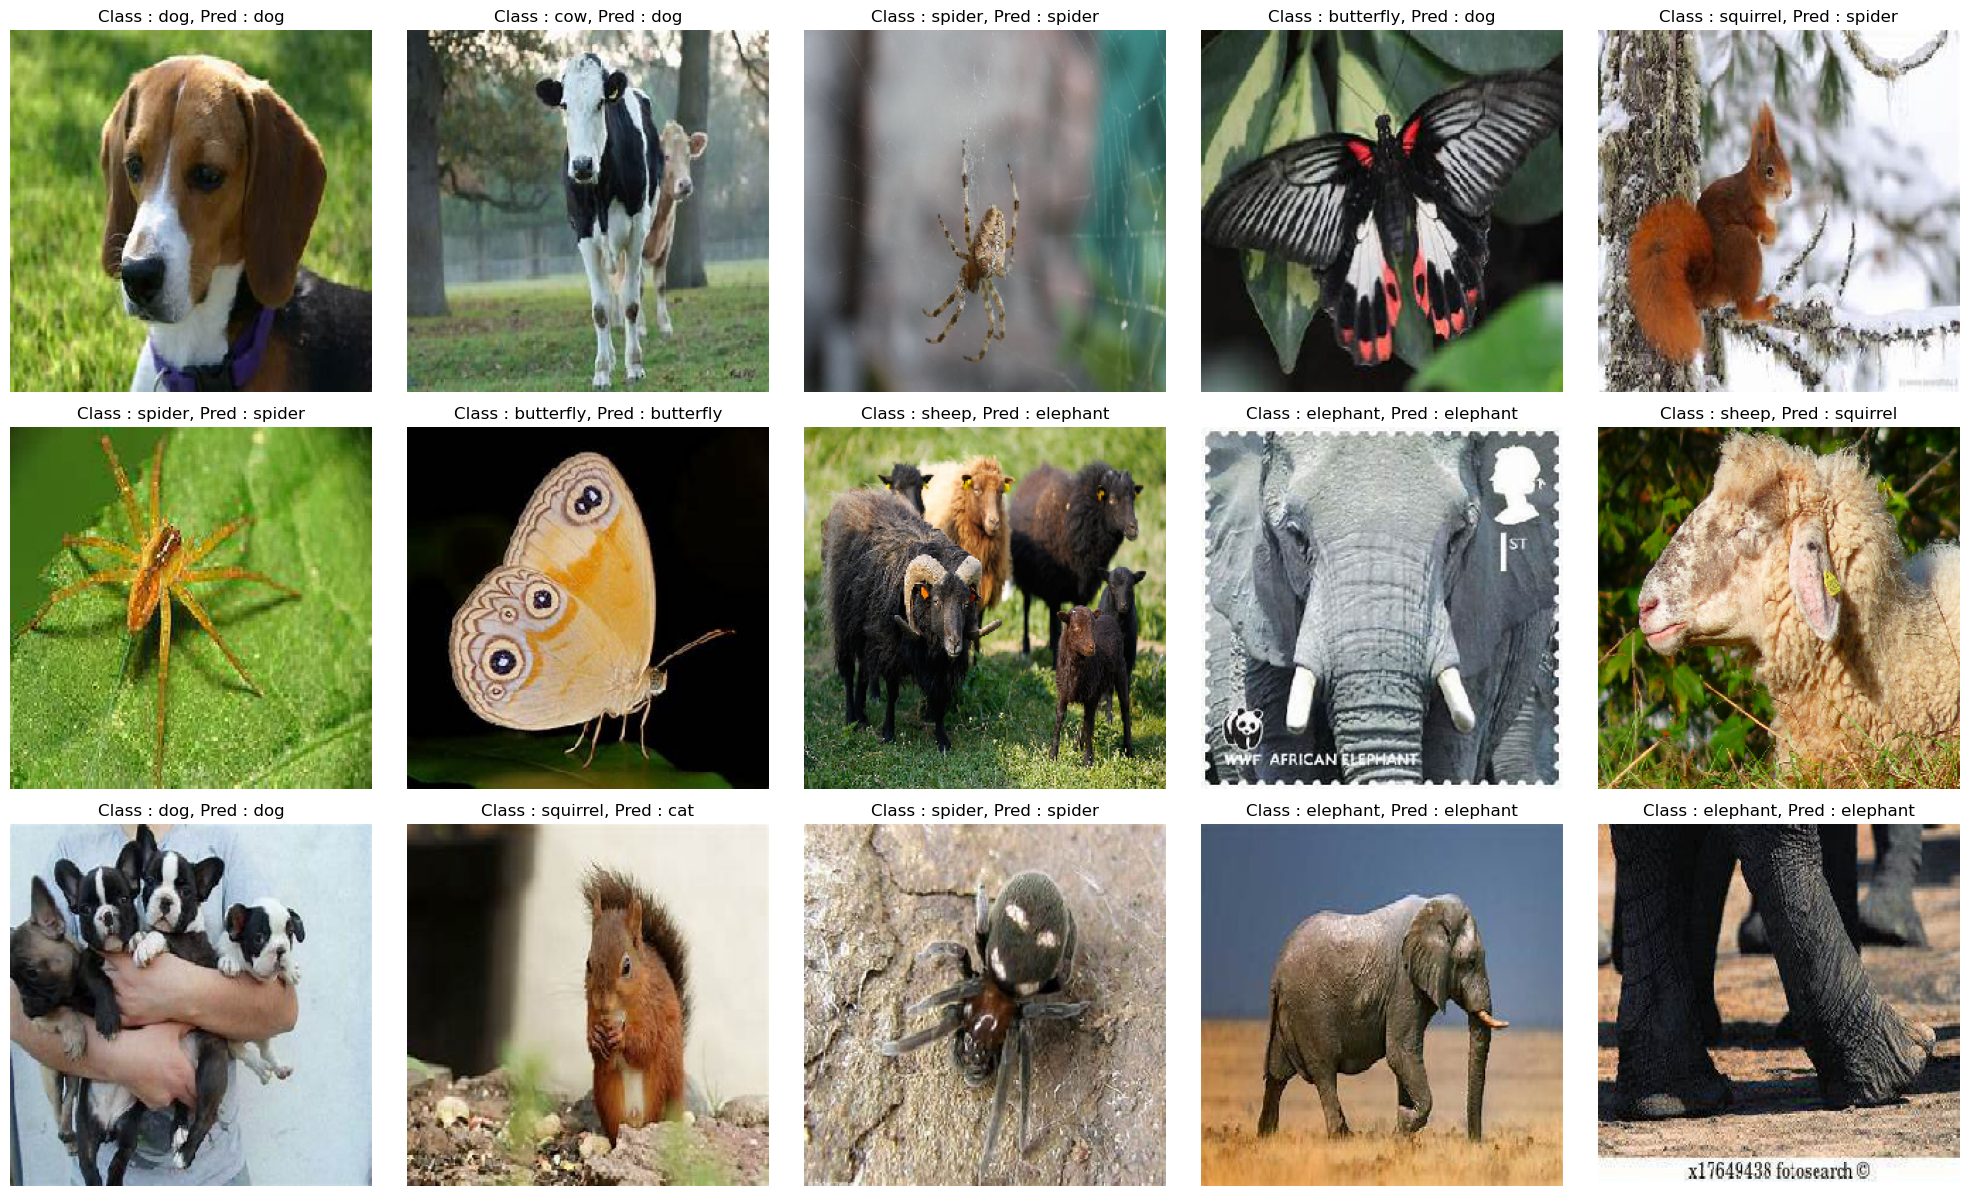

In [31]:
plt.figure(figsize=(20,20))

i=1
for images, labels in iter(test_data):
  img, lbl = get_random_data([images, labels])
  pred_lbl = class_names[np.argmax(image_classifier.predict(img[np.newaxis, ...]))]

  plt.subplot(5,5,i)
  show_image(img, image_title=f"Class : {class_names[int(lbl)]}, Pred : {pred_lbl}")

  i +=1
  if i>=16:break

plt.tight_layout()
plt.show()